In [11]:
#!/usr/bin/env pythonP 
# coding: utf-8 

import netCDF4 as nc 
import sys, os, argparse 
import time 
import numpy as np 
from numpy import ma as ma 
from itertools import combinations 

#Import packages for plotting 
from matplotlib import pyplot as plt 
from matplotlib import colors as mcolors 
import matplotlib.animation as animation 
from matplotlib.ticker import MaxNLocator 
from pylab import imshow,cm 

#Import packages for clustering 
from sklearn.cluster import KMeans 
from k_means_constrained import KMeansConstrained 
from scipy.linalg import eigh 

#Import packages for geodesic distences 
from pyproj import Geod 


#Import packages for interpolating and filtering data 
from scipy.spatial import ConvexHull, convex_hull_plot_2d 
from scipy.interpolate import LinearNDInterpolator as LNDI 

# Import package for parallel computing 
from joblib import Parallel, delayed  




In [12]:

IC_resolution = 0.5 
dt = 0.0025 
DT = 0.01 
freq = 1 
geodesic = True 
e = 0 
n_clusters = 20 
# Format the variables 
formatted_e = f"{e:.2f}"
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"
# Define other necessary variables 
year = 2009 
season ="AMJ"
# Construct file paths and directories 
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
directory =  f"/cluster/projects/nn8008k/lluisa/NextSIM/seas/{season}/"#f"/nird/projects/NS11048K/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/"
file_path = f"{directory}Fmap_10days/{Fmap_params}/"
parent_directory ="/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
results_directory = file_path 
regrided_geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}_regrided.nc"
geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}.nc"
K=1000 
distance = 4 
k_exp = 100  



Cluster_params = ( 
    f"geodesic_{geodesic}_"
    f"nclusters{n_clusters}_"
    f"e{e:.2f}"
) 




In [13]:
# add utils folder to the TBarrier package 
#sys.path.append(T_Barrier_directory"/subfunctions/utils") 
#sys.path.append(T_Barrier_directory"/subfunctions/integration") 
# add utils folder to current working path 
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering") 
sys.path.append(parent_directory+"/utils") 
sys.path.append(parent_directory+"/subfunctions/Parallelisation") 
sys.path.append(parent_directory+"/subfunctions/latlon_transform") 
 

sys.path.append(parent_directory+"/subfunctions/trajectory_advection") 
from Interpolant import generate_land_mask_interpolator  

from from_similarity_to_eigen import from_similarity_to_eigen, from_similarity_to_eigen_W, cut_trajectories_in_W #, from_similarity_to_eigen_cut_zones 

from ploters import ini_final_clusters 
from ploters import gif_clusters 
from ploters import ini_final_clusters_landmask 
from ploters import ini_final_clusters_landmask_ini 
from ploters import gif_clusters_landmask 
from degrees import degree_matrix 
from polar_rotation import polar_rotation_rx  



print("Reading data") 
#Read input data 
Fmap_path = file_path+'/0_Fmap_matrix.npy' 
time_path = file_path+'/0_advection_time.npy' 
W_path = file_path+'/0_W_matrix.npy' 

# Load the Fmap array from the file 
Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories 
#Fmap=Fmap[:,:,::100] 
# Load the time_adv_mod array from the file 
time_adv_mod = np.load(time_path) 
# Load the similarity matrix 
W_vec = np.load(W_path) 

dataset = nc.Dataset(regrided_geo_file_path, mode='r') 
#from m/s to m/day 
siu = dataset.variables['vlon'][0,:,:] 
land_mask_reg = dataset.variables['land_mask'][:,:] 
# Access coordinates 
latitude_reg = dataset.variables['regrided_rot_lat'][:]   
longitude_reg = dataset.variables['regrided_rot_lon'][:] 
dataset.close() 

dataset = nc.Dataset(geo_file_path, mode='r') 
#from m/s to m/day 
land_mask = dataset.variables['vlon'][0,:,:].mask 
print("shape of land mask") 
print(str(land_mask.shape)) 
# Access coordinates 
latitude = dataset.variables['rot_lat'][:]   
longitude = dataset.variables['rot_lon'][:] 
dataset.close()  



Reading data
shape of land mask
(492, 499)


In [61]:
n=Fmap.shape[2] 
indices = np.tril_indices(n,0,n) 
# Create an empty matrix of zeros with shape (n, n) 
W = np.zeros((n, n)) 
W[indices] = W_vec 
# Fill the upper triangular part  
W = W + W.T - np.diag(np.diag(W)) 
np.fill_diagonal(W,1000) 

In [62]:
W

array([[1.00000000e+03, 1.14064775e-03, 1.20082985e-03, ...,
        1.48376724e-04, 1.47364335e-04, 1.47543794e-04],
       [1.14064775e-03, 1.00000000e+03, 2.25934768e-02, ...,
        1.51885872e-04, 1.50624633e-04, 1.50629545e-04],
       [1.20082985e-03, 2.25934768e-02, 1.00000000e+03, ...,
        1.51862347e-04, 1.50611121e-04, 1.50625461e-04],
       ...,
       [1.48376724e-04, 1.51885872e-04, 1.51862347e-04, ...,
        1.00000000e+03, 1.31386325e-02, 8.49780294e-03],
       [1.47364335e-04, 1.50624633e-04, 1.50611121e-04, ...,
        1.31386325e-02, 1.00000000e+03, 1.93283138e-02],
       [1.47543794e-04, 1.50629545e-04, 1.50625461e-04, ...,
        8.49780294e-03, 1.93283138e-02, 1.00000000e+03]],
      shape=(3851, 3851))

In [16]:
W_path_old = file_path+'/0_W_matrix_geodesic_True.npy' 

# Load the similarity matrix 
W_vec_old = np.load(W_path_old) 

In [17]:
n=Fmap.shape[2] 
indices = np.tril_indices(n,0,n) 
# Create an empty matrix of zeros with shape (n, n) 
W_old = np.zeros((n, n)) 
W_old[indices] = W_vec_old 
# Fill the upper triangular part  
#W = W + W.T - np.diag(np.diag(W)) 
#np.fill_diagonal(W,0) 



In [21]:
d_old=1/W_old

/tmp/ipykernel_687292/2187985583.py:1: RuntimeWarning: divide by zero encountered in divide
  d_old=1/W_old


In [20]:
d=1/W

/tmp/ipykernel_687292/3366700030.py:1: RuntimeWarning: divide by zero encountered in divide
  d=1/W


In [42]:
d_old/975/1000-d

/tmp/ipykernel_687292/1498139516.py:1: RuntimeWarning: invalid value encountered in subtract
  d_old/975/1000-d


array([[-9.99998974e-04,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 2.27373675e-13, -9.99998974e-04,             nan, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00, -2.13162821e-14, -9.99998974e-04, ...,
                    nan,             nan,             nan],
       ...,
       [ 3.63797881e-12, -9.09494702e-13,  9.09494702e-13, ...,
        -9.99998974e-04,             nan,             nan],
       [ 9.09494702e-13, -1.81898940e-12,  2.72848411e-12, ...,
         1.42108547e-14, -9.99998974e-04,             nan],
       [ 0.00000000e+00, -9.09494702e-13,  2.72848411e-12, ...,
         0.00000000e+00,  1.42108547e-14, -9.99998974e-04]],
      shape=(3851, 3851))

In [55]:
a = W_cut_15[np.tril_indices(W_cut_15.shape[0], k=-1)]

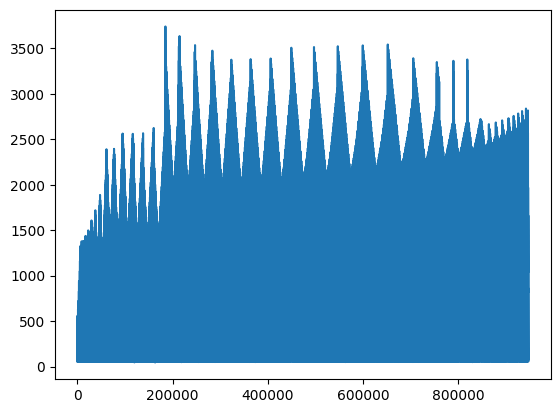

In [58]:
plt.plot(1/a)

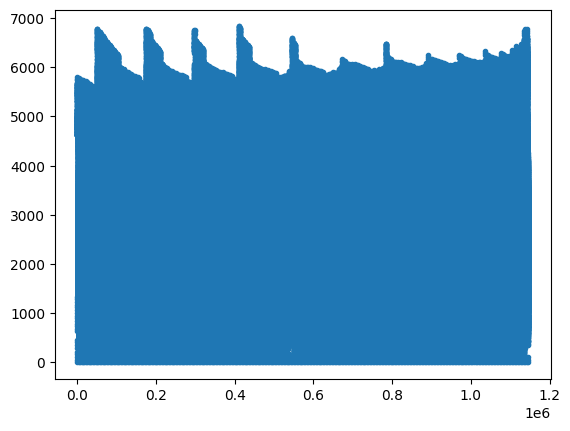

In [53]:
plt.plot(1/W_vec[6271088:7472110],'.')

In [22]:
time_adv_mod.shape

(976,)

In [28]:
Fmap.shape

(976, 2, 3851)

In [29]:
IC = Fmap[0,:,]

In [30]:
params = f"01_04_{year}_"
params += f"ic{IC_resolution}_"
params += f"dt{formatted_dt}_"
params += f"DT{formatted_DT} "

params 
 


'01_04_2009_ic0.5_dt0.0025_DT0.0100 '

In [31]:

def cut_trajectories_in_W(Fmap, W_vec,e,distance,land_mask,latitude,longitude): 
    n=Fmap.shape[2] 
    indices = np.tril_indices(n,0,n) 
    print("The percentage of spercified elements is "+str(np.sum(W_vec < e)/np.sum(W_vec))) 
    W_vec[W_vec < e] = 0 

    # Create an empty matrix of zeros with shape (n, n) 
    W = np.zeros((n, n)) 
    W[indices] = W_vec 
    # Fill the upper triangular part  
    W = W + W.T - np.diag(np.diag(W)) 

    from scipy.ndimage import binary_dilation 
    # Define the number of cells to expand the mask 
    # Create a structuring element for dilation 
    structuring_element = np.ones((2 * distance + 1, 2 * distance + 1)) 
    # Perform binary dilation to expand the mask 
    thick_land_mask = binary_dilation(land_mask, structure=structuring_element) 
    from shapely.geometry import Point, Polygon 
    # Define the vertices of the polygon 
    #Canadian archipelago 
    polygon_vertices = [ 
        (-20,-110), 
        (10, -50),   # Vertex 2 (latitude, longitude) 
        (-35, -50),    # Vertex 4 (latitude, longitude) 
        (-40, -90) 
    ] 
    # Create a Polygon object using shapely 
    polygon = Polygon(polygon_vertices) 
    # Flatten the latitude and longitude matrices to create a list of points 
    points = np.column_stack((latitude.ravel(), longitude.ravel())) 
    # Use a list comprehension to check if each point is inside the polygon 
    inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points]) 
    # Reshape the mask back to the original shape of the latitude matrix 
    polygon_land_mask = inside_mask.reshape(latitude.shape) 
    # Count the number of points inside the polygon 
    inside_points_count = np.sum(polygon_land_mask) 
    #Russian coast 
    polygon_vertices = [ 
        (26,-70), 
        (15, -98),   # Vertex 2 (latitude, longitude) 
        (-20, -52),    # Vertex 4 (latitude, longitude) 
        (-4, -54) 
    ] 
    # Create a Polygon object using shapely 
    polygon = Polygon(polygon_vertices) 
    # Flatten the latitude and longitude matrices to create a list of points 
    points = np.column_stack((latitude.ravel(), longitude.ravel())) 
    # Use a list comprehension to check if each point is inside the polygon 
    inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points]) 
    # Reshape the mask back to the original shape of the latitude matrix 
    polygon_land_mask = polygon_land_mask + inside_mask.reshape(latitude.shape) 
    
    # Count the number of points inside the polygon 
    inside_points_count = np.sum(polygon_land_mask) 

    # Output the number of points inside the polygon 
    print("Number of points inside the polygons:") 
    print(str(inside_points_count)) 
    expanded_land_mask = thick_land_mask + polygon_land_mask 
    exp_land_mask = generate_land_mask_interpolator(latitude,longitude,expanded_land_mask) 
    print("Finally finished generating interpolator!") 
    Fmap_mask = exp_land_mask(Fmap[:,1,:],Fmap[:,0,:]) 
    IC_mask = np.sum(Fmap_mask,axis=0) 
    IC_mask_final = np.where(IC_mask > 0)[0] 
    W = np.delete(W, IC_mask_final, axis=0)  # Remove rows 
    W = np.delete(W, IC_mask_final, axis=1) 
    Fmap = np.delete(Fmap, IC_mask_final, axis=2)     
    print(str(IC_mask_final.shape)+" trajectories have been removed because they were too close to land or ending up too close to land") 
    return W, Fmap 



In [32]:

def cut_trajectories_in_W_with_Russian_coast(Fmap, W_vec,e,distance,land_mask,latitude,longitude): 
    n=Fmap.shape[2] 
    indices = np.tril_indices(n,0,n) 
    print("The percentage of spercified elements is "+str(np.sum(W_vec < e)/np.sum(W_vec))) 
    W_vec[W_vec < e] = 0 

    # Create an empty matrix of zeros with shape (n, n) 
    W = np.zeros((n, n)) 
    W[indices] = W_vec 
    # Fill the upper triangular part  
    W = W + W.T - np.diag(np.diag(W)) 

    from scipy.ndimage import binary_dilation 
    # Define the number of cells to expand the mask 
    # Create a structuring element for dilation 
    structuring_element = np.ones((2 * distance + 1, 2 * distance + 1)) 
    # Perform binary dilation to expand the mask 
    thick_land_mask = binary_dilation(land_mask, structure=structuring_element) 
    from shapely.geometry import Point, Polygon 
    # Define the vertices of the polygon 
    #Canadian archipelago 
    polygon_vertices = [ 
        (-20,-110), 
        (10, -50),   # Vertex 2 (latitude, longitude) 
        (-35, -50),    # Vertex 4 (latitude, longitude) 
        (-40, -90) 
    ] 
    # Create a Polygon object using shapely 
    polygon = Polygon(polygon_vertices) 
    # Flatten the latitude and longitude matrices to create a list of points 
    points = np.column_stack((latitude.ravel(), longitude.ravel())) 
    # Use a list comprehension to check if each point is inside the polygon 
    inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points]) 
    # Reshape the mask back to the original shape of the latitude matrix 
    polygon_land_mask = inside_mask.reshape(latitude.shape) 
    # Count the number of points inside the polygon 
    inside_points_count = np.sum(polygon_land_mask) 

    # Output the number of points inside the polygon 
    print("Number of points inside the polygons:") 
    print(str(inside_points_count)) 
    expanded_land_mask = thick_land_mask + polygon_land_mask 
    exp_land_mask = generate_land_mask_interpolator(latitude,longitude,expanded_land_mask) 
    print("Finally finished generating interpolator!") 
    Fmap_mask = exp_land_mask(Fmap[:,1,:],Fmap[:,0,:]) 
    IC_mask = np.sum(Fmap_mask,axis=0) 
    IC_mask_final = np.where(IC_mask > 0)[0] 
    W = np.delete(W, IC_mask_final, axis=0)  # Remove rows 
    W = np.delete(W, IC_mask_final, axis=1) 
    Fmap = np.delete(Fmap, IC_mask_final, axis=2)     
    print(str(IC_mask_final.shape)+" trajectories have been removed because they were too close to land or ending up too close to land") 
    return W, Fmap 



In [33]:


W_cut, Fmap_cut = cut_trajectories_in_W(Fmap, W_vec,e,distance,land_mask_reg,latitude_reg,longitude_reg) 
W_cut.shape 
Fmap_cut.shape 
IC_cut=Fmap_cut[0,:,:] 



W_cut_with_Russian_coast, Fmap_cut_with_Russian_coast = cut_trajectories_in_W_with_Russian_coast(Fmap, W_vec,e,distance,land_mask_reg,latitude_reg,longitude_reg) 
W_cut_with_Russian_coast.shape 
Fmap_cut_with_Russian_coast.shape 
IC_cut_with_Russian_coast=Fmap_cut_with_Russian_coast[0,:,:] 



W_cut_15, Fmap_cut_15 = cut_trajectories_in_W(Fmap, W_vec,e,10,land_mask_reg,latitude_reg,longitude_reg) 
W_cut_15.shape 
Fmap_cut_15.shape 
IC_cut_15=Fmap_cut_15[0,:,:] 



The percentage of spercified elements is 0.0
Number of points inside the polygons:
105846
Finally finished generating interpolator!
(2014,) trajectories have been removed because they were too close to land or ending up too close to land
The percentage of spercified elements is 0.0
Number of points inside the polygons:
80133
Finally finished generating interpolator!
(1786,) trajectories have been removed because they were too close to land or ending up too close to land
The percentage of spercified elements is 0.0
Number of points inside the polygons:
105846
Finally finished generating interpolator!
(2474,) trajectories have been removed because they were too close to land or ending up too close to land


In [34]:

def ini_final_clusters_landmask_ini(IC, img_name, e, x, y, mask_interpol, aspect_ratio=1): 
    positions_ini = IC 
    
    """ 
    ymax = Fmap[:, 1, :].max() 
    ymin = Fmap[:, 1, :].min() 
    xmax = Fmap[:, 0, :].max() 
    xmin = Fmap[:, 0, :].min() 
    """ 
    ymax = 25 
    ymin = -40 
    xmax = -45 
    xmin = -115 
    
    # Create a figure with a fixed size 
    fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as needed 
    
    
    # Define color map for the landmask 
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white 
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask) 
    colors_mask = plt.get_cmap(custom_cmap, 2) 
    
    # Plot the initial distribution 
    #ax.scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=mask_interpol, cmap=colors_mask) 
    color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto') 
    #ax.pcolormesh(x.ravel(), y.ravel(), mask_interpol.ravel(), cmap=colors_mask, shading='auto') 
    ax.scatter(positions_ini[0, :], positions_ini[1, :],s=0.3,color="red") 
    
    # Set axis labels and title with larger font sizes 
    ax.set_xlabel("Rotated Longitude", fontsize=14) 
    ax.set_ylabel("Rotated Latitude", fontsize=14) 
    #ax.set_title("Initial distribution of the clusters", fontsize=16) 
    
    # Set limits with some padding 
    #ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin)) 
    #ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin)) 
    #ax.set_xlim(x.min() - 0.05 * (x.max() - x.min()), x.max() + 0.05 * (x.max() - x.min())) 
    #ax.set_ylim(y.min() - 0.05 * (y.max() - y.min()), y.max() + 0.05 * (y.max() - y.min())) 
    ax.set_aspect(aspect_ratio)  # Set a specific aspect ratio 
    
    # Add legend outside the plot 
    """ 
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=cluster_names[j], 
                        markerfacecolor=colors(j), markersize=8) for j in range(n_clusters)] 
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.) 
    """ 
    # Main title with larger font size 
    plt.title(f"INITIAL CONDITIONS", fontsize=16) 
    
    # Adjust layout to make room for the legend 
    plt.tight_layout(rect=[0, 0, 0.85, 0.95]) 
    
    # Save the figure 
    plt.show() 
    #plt.savefig(img_name, bbox_inches='tight') 
    plt.close(fig)  # Close the figure to free up memory 




In [35]:
IC.shape

(2, 3851)

/tmp/ipykernel_1437041/491269001.py:26: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


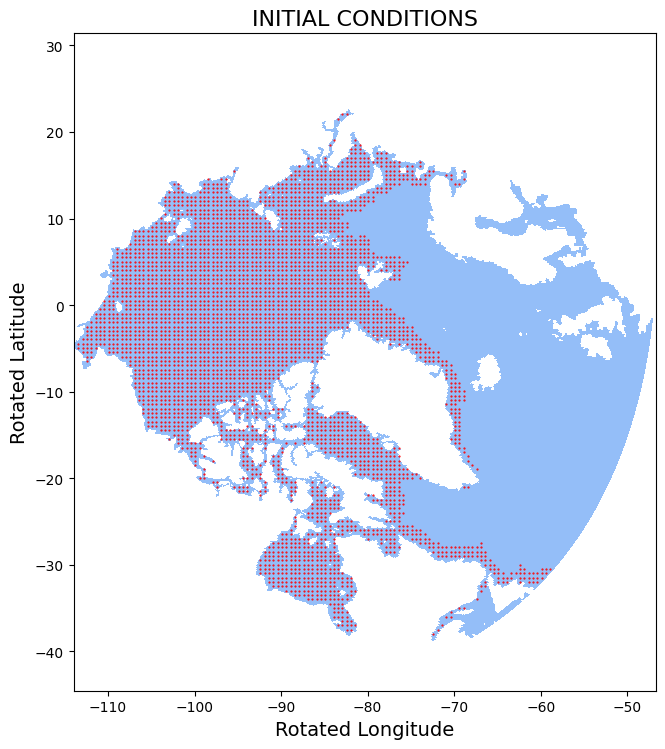

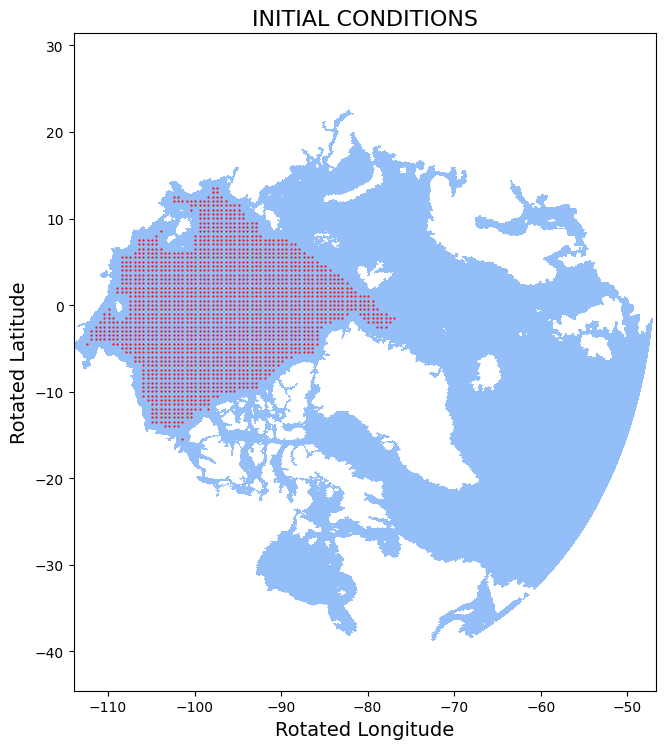

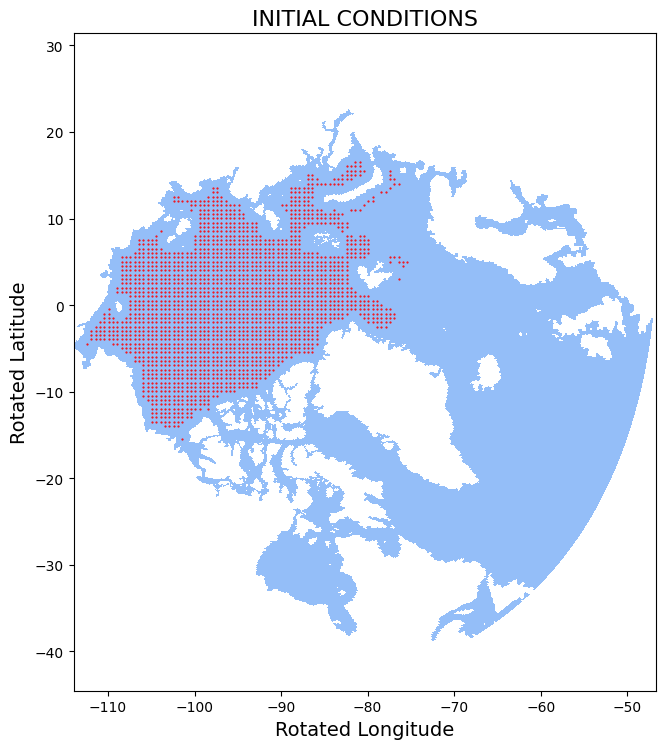

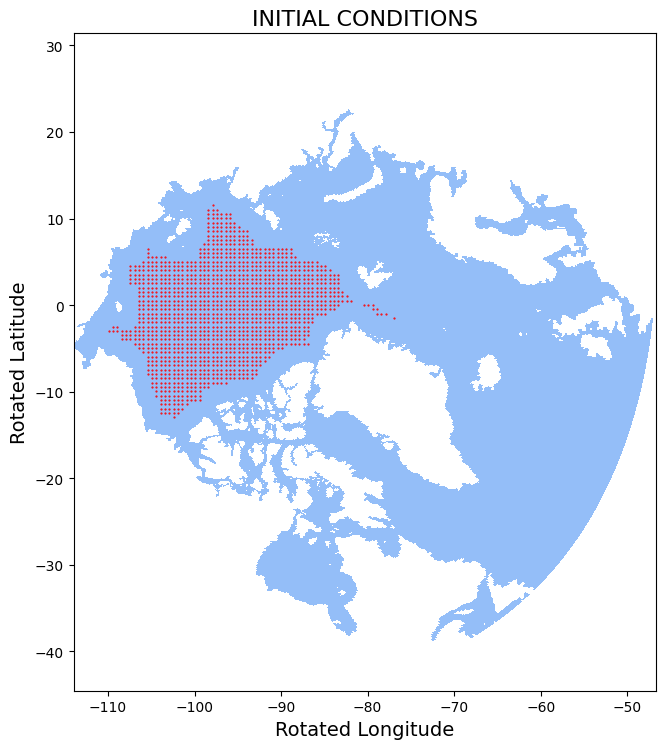

In [25]:

ini_final_clusters_landmask_ini(IC, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)  
ini_final_clusters_landmask_ini(IC_cut, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask) 
ini_final_clusters_landmask_ini(IC_cut_with_Russian_coast, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)  
ini_final_clusters_landmask_ini(IC_cut_15, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)  

latitude_back, longitude_back = polar_rotation_rx(np.array(latitude),np.array(longitude),-90) 

IC_rot_lat, IC_rot_lon = polar_rotation_rx(IC[1], IC[0],-90) 
IC_rot = np.asarray(np.vstack((IC_rot_lon,IC_rot_lat))) 
IC_cut_rot_lat, IC_cut_rot_lon = polar_rotation_rx(IC_cut[1], IC_cut[0],-90) 
IC_cut_rot = np.asarray(np.vstack((IC_cut_rot_lon,IC_cut_rot_lat))) 
IC_cut_with_Russian_coast_rot_lat, IC_cut_with_Russian_coast_rot_lon = polar_rotation_rx(IC_cut_with_Russian_coast[1], IC_cut_with_Russian_coast[0],-90) 
IC_cut_with_Russian_coast_rot = np.asarray(np.vstack((IC_cut_with_Russian_coast_rot_lon,IC_cut_with_Russian_coast_rot_lat))) 
IC_cut_15_rot_lat, IC_cut_15_rot_lon = polar_rotation_rx(IC_cut_15[1], IC_cut_15[0],-90) 
IC_cut_15_rot = np.asarray(np.vstack((IC_cut_15_rot_lon,IC_cut_15_rot_lat))) 



In [26]:

def ini_final_clusters_landmask_ini(IC, img_name, e, x, y, mask_interpol, aspect_ratio=1): 
    positions_ini = IC 
    
    """ 
    ymax = Fmap[:, 1, :].max() 
    ymin = Fmap[:, 1, :].min() 
    xmax = Fmap[:, 0, :].max() 
    xmin = Fmap[:, 0, :].min() 
    """ 
    ymax = 25 
    ymin = -40 
    xmax = -45 
    xmin = -115 
    
    # Create a figure with a fixed size 
    fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as needed 
    
    
    # Define color map for the landmask 
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white 
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask) 
    colors_mask = plt.get_cmap(custom_cmap, 2) 
    
    # Plot the initial distribution 
    #ax.scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=mask_interpol, cmap=colors_mask) 
    color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto') 
    #ax.pcolormesh(x.ravel(), y.ravel(), mask_interpol.ravel(), cmap=colors_mask, shading='auto') 
    ax.scatter(positions_ini[0, :], positions_ini[1, :],s=0.3,color="red") 
    
    # Set axis labels and title with larger font sizes 
    ax.set_xlabel("Rotated Longitude", fontsize=14) 
    ax.set_ylabel("Rotated Latitude", fontsize=14) 
    #ax.set_title("Initial distribution of the clusters", fontsize=16) 
    
    # Set limits with some padding 
    #ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin)) 
    #ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin)) 
    #ax.set_xlim(x.min() - 0.05 * (x.max() - x.min()), x.max() + 0.05 * (x.max() - x.min())) 
    #ax.set_ylim(y.min() - 0.05 * (y.max() - y.min()), y.max() + 0.05 * (y.max() - y.min())) 
    ax.set_aspect(aspect_ratio)  # Set a specific aspect ratio 
    
    # Add legend outside the plot 
    """ 
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=cluster_names[j], 
                        markerfacecolor=colors(j), markersize=8) for j in range(n_clusters)] 
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.) 
    """ 
    # Main title with larger font size 
    plt.title(f"INITIAL CONDITIONS", fontsize=16) 
    
    # Adjust layout to make room for the legend 
    plt.tight_layout(rect=[0, 0, 0.85, 0.95]) 
    
    # Save the figure 
    plt.show() 
    #plt.savefig(img_name, bbox_inches='tight') 
    plt.close(fig)  # Close the figure to free up memory 



In [37]:

import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature  



def plotpolar(IC, img_name, e, x, y, mask_interpol, aspect_ratio=1): 
    positions_ini = IC 
    # Ensure x and y are 2D arrays (if they are 1D, convert them using meshgrid) 
    if x.ndim == 1 and y.ndim == 1: 
        x, y = np.meshgrid(x, y) 
    # Create a figure with a polar stereographic projection centered on the North Pole 
    fig, ax = plt.subplots( 
        figsize=(8, 8), 
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection 
    ) 

    # Plot the initial cluster positions 
    ax.scatter( 
        positions_ini[0, :], positions_ini[1, :], 
        s=0.3, color="red", 
        transform=ccrs.PlateCarree()  # Specify the coordinate system of the data 
    ) 
    # Add coastlines and gridlines 
    ax.coastlines(resolution='50m', color='black', linewidth=0.8) 
    ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5) 
    # Set the extent to focus on the North Pole 
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree()) 
    # Add a title 
    plt.title("INITIAL CONDITIONS", fontsize=16) 
    # Save and show the plot 
    plt.tight_layout() 
    plt.show() 
    # plt.savefig(img_name, bbox_inches='tight') 
    plt.close(fig)  # Close the figure to free up memory 


In [38]:
IC_cut_rot.shape

NameError: name 'IC_cut_rot' is not defined

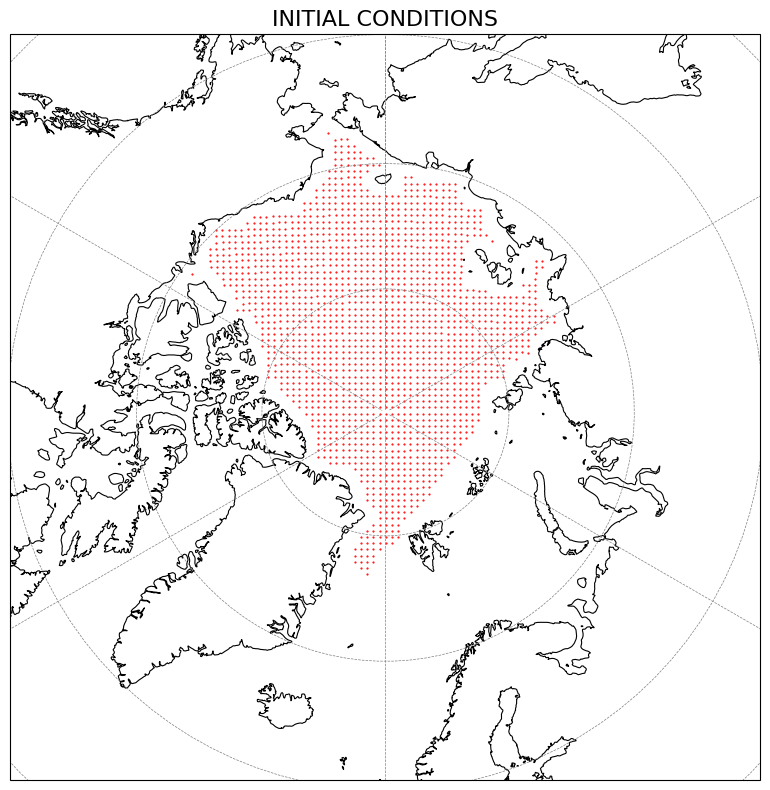

In [28]:
plotpolar(IC_cut_rot, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, np.asarray(longitude_back), np.asarray(latitude_back), land_mask)  


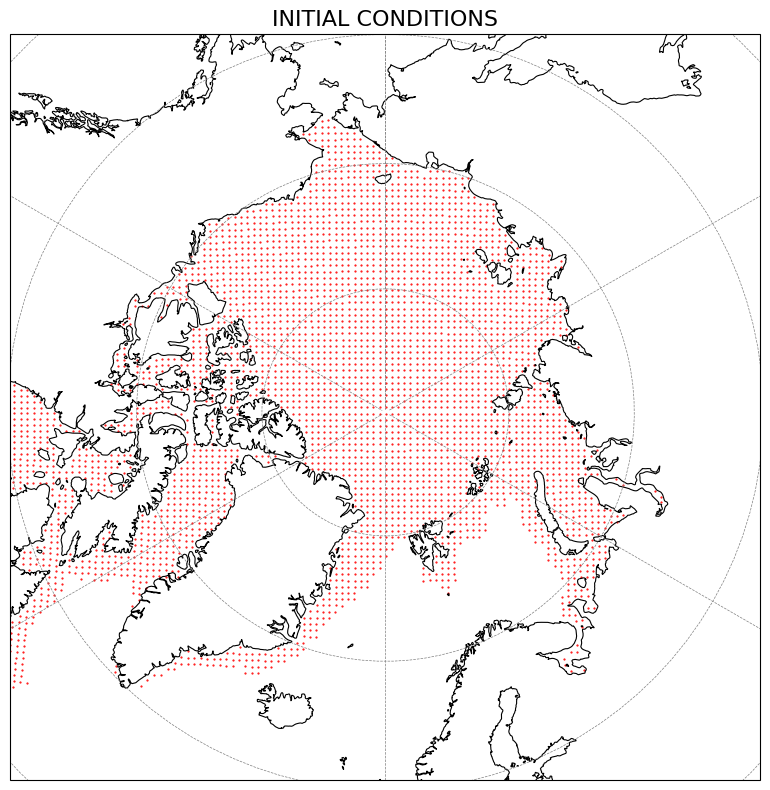

In [29]:
plotpolar(IC_rot, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, np.asarray(longitude_back), np.asarray(latitude_back), land_mask)  


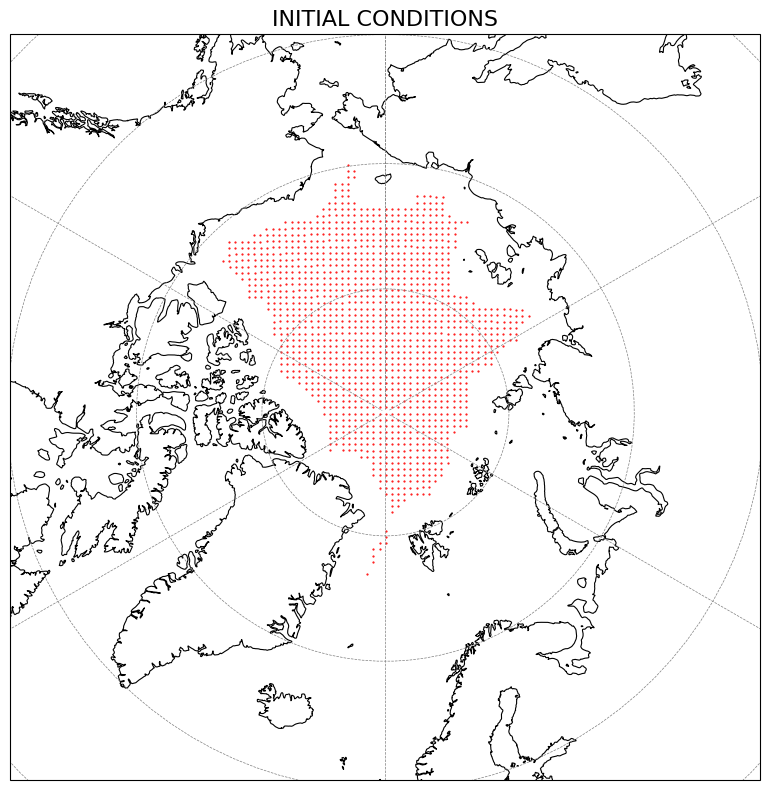

In [30]:
plotpolar(IC_cut_15_rot, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, np.asarray(longitude_back), np.asarray(latitude_back), land_mask)  


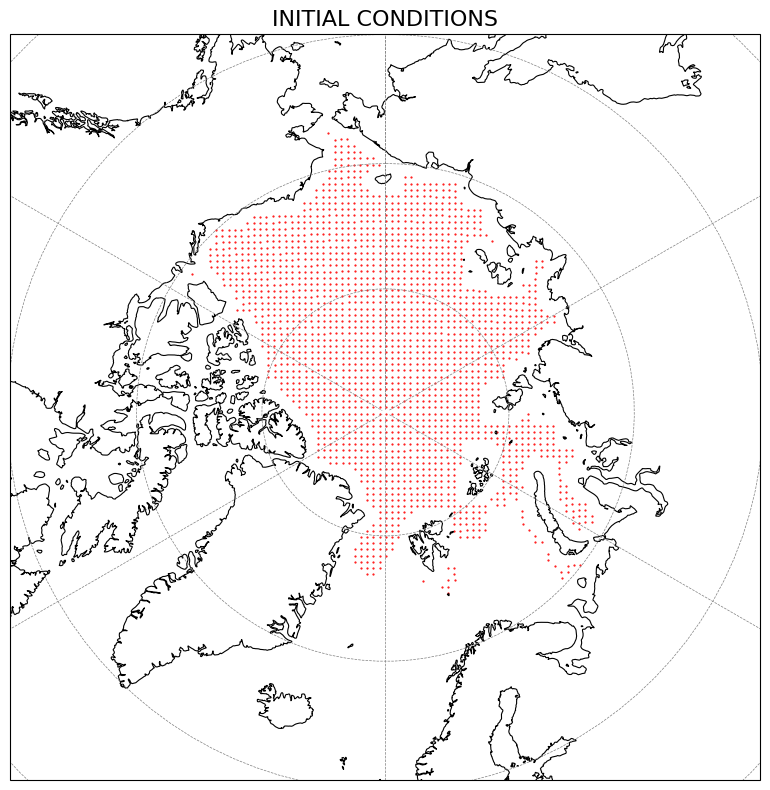

In [31]:
plotpolar(IC_cut_with_Russian_coast_rot, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, np.asarray(longitude_back), np.asarray(latitude_back), land_mask)  


In [32]:

np.savetxt("IC_"+params+".csv",IC_rot.T,delimiter=",") 
np.savetxt("IC_"+params+"_cut.csv",IC_cut_rot.T,delimiter=",") 
np.savetxt("IC_"+params+"_cut_15.csv",IC_cut_15_rot.T,delimiter=",") 
np.savetxt("IC_"+params+"_cut_with_Russian_coast.csv",IC_cut_with_Russian_coast_rot.T,delimiter=",") 



In [64]:
np.savetxt("W_"+params+".csv",W,delimiter=",") 

In [39]:
np.savetxt("W_"+params+".csv",W,delimiter=",") 
np.savetxt("IC_"+params+".csv",IC,delimiter=",") 
np.savetxt("W_"+params+"_cut.csv",W_cut,delimiter=",") 
np.savetxt("IC_"+params+"_cut.csv",IC_cut,delimiter=",") 
np.savetxt("W_"+params+"_cut_15.csv",W_cut_15,delimiter=",") 
np.savetxt("IC_"+params+"_cut_15.csv",IC_cut_15,delimiter=",") 
np.savetxt("W_"+params+"_cut_with_Russian_coast.csv",W_cut_with_Russian_coast,delimiter=",") 
np.savetxt("IC_"+params+"_cut_with_Russian_coast.csv",IC_cut_with_Russian_coast,delimiter=",")